In [ ]:
!umount -l /content/drive

umount: /content/drive: no mount point specified.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install texttable

In [ ]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from texttable import Texttable

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Update the paths according to your dataset location
MODEL_LOC = '/content/drive/MyDrive/chest_xray/pneumonia_detection_cnn_model.h5'

DATA_DIR = '/content/drive/MyDrive/chest_xray/'
TRAINING_DATA_DIR = DATA_DIR + 'train/'     # Notice: Removed extra '/'
TEST_DATA_DIR = DATA_DIR + 'test/'
VAL_DATA_DIR = DATA_DIR + 'val/'

# Classes present in the dataset
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
# Function to count images
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

In [ ]:
# Display Dataset Summary
t = Texttable()
t.add_rows([
    ['Dataset Type', 'Normal', 'Pneumonia'],
    ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')],
    ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
    ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')]
])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1341   | 3875      |
+--------------+--------+-----------+
| Test         | 234    | 390       |
+--------------+--------+-----------+
| Validation   | 8      | 8         |
+--------------+--------+-----------+


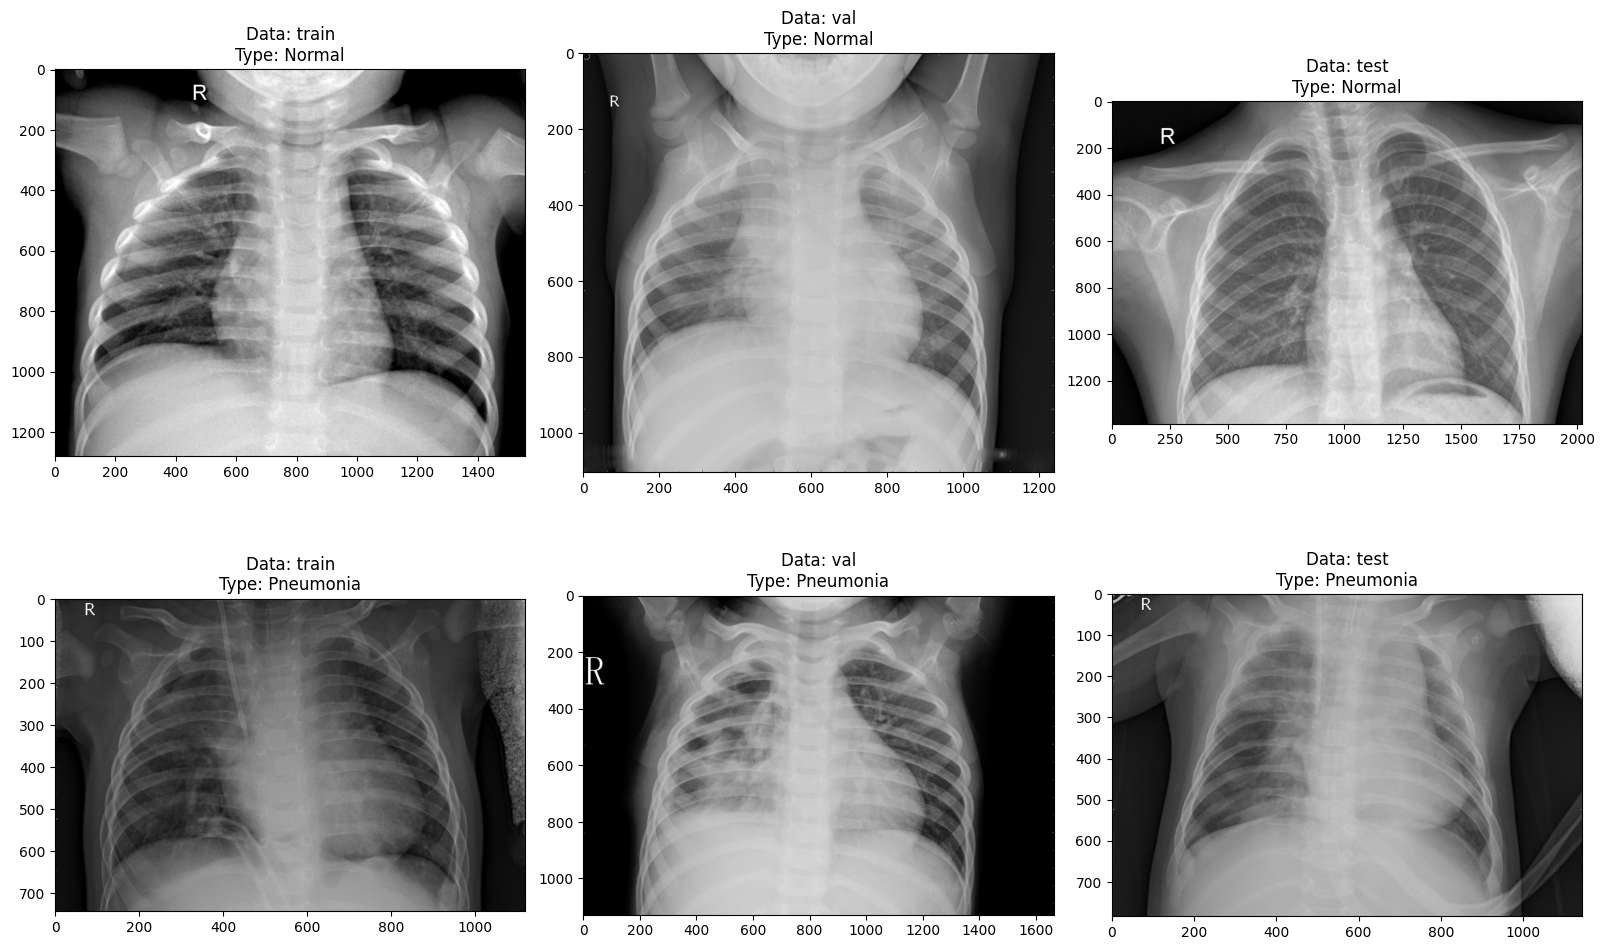

In [ ]:
# Display Sample Images
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['train', 'val', 'test']):
    image_path = DATA_DIR + subdir
    ax[i].imshow(plt.imread(f'{image_path}/NORMAL/{os.listdir(image_path + "/NORMAL")[0]}'), cmap='gray')
    ax[i].set_title(f'Data: {subdir}\nType: Normal', fontsize=12)

    ax[i+3].imshow(plt.imread(f'{image_path}/PNEUMONIA/{os.listdir(image_path + "/PNEUMONIA")[0]}'), cmap='gray')
    ax[i+3].set_title(f'Data: {subdir}\nType: Pneumonia', fontsize=12)

plt.show()

In [ ]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    shear_range=0.2,
    vertical_flip=True,
    rotation_range=10,
    zoom_range=0.3
)

training_dataset = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    classes=DETECTION_CLASSES,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(224, 224)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_dataset = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    classes=DETECTION_CLASSES,
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=(224, 224)
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_dataset = val_datagen.flow_from_directory(
    VAL_DATA_DIR,
    classes=DETECTION_CLASSES,
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=(224, 224)
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# Class Indices Check
print(f'class indices: {training_dataset.class_indices}')

class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:

# Build CNN Model
cnn_model = Sequential()

cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.7))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.summary()

# Compile Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_8 (SeparableConv2D) │ (None, 112, 112, 32)        │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_9 (SeparableConv2D) │ (None, 112, 112, 32)        │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_10                  │ (None, 56, 56, 64)          │           2,400 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_11                  │ (None, 56, 56, 64)          │           4,736 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_12                  │ (None, 28, 28, 128)         │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_13                  │ (None, 28, 28, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_14                  │ (None, 14, 14, 256)         │          34,176 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,639,778 (25.33 MB)

 Trainable params: 6,638,818 (25.33 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=MODEL_LOC, monitor='val_loss', save_best_only=True, mode='min')

In [ ]:
# Train Model
history = cnn_model.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7753 - loss: 0.4607

163/163 ━━━━━━━━━━━━━━━━━━━━ 1551s 9s/step - accuracy: 0.7756 - loss: 0.4602 - val_accuracy: 0.6250 - val_loss: 0.7534
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8608 - loss: 0.2993

163/163 ━━━━━━━━━━━━━━━━━━━━ 718s 4s/step - accuracy: 0.8609 - loss: 0.2992 - val_accuracy: 0.3750 - val_loss: 0.7436
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8857 - loss: 0.2774

163/163 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.8857 - loss: 0.2774 - val_accuracy: 0.6250 - val_loss: 0.6985
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 698s 4s/step - accuracy: 0.8980 - loss: 0.2607 - val_accuracy: 0.6250 - val_loss: 0.7936
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 752s 4s/step - accuracy: 0.9099 - loss: 0.2278 - val_accuracy: 0.3798 - val_loss: 0.9641
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9215 - loss: 0.2089

163/163 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.9215 - loss: 0.2090 - val_accuracy: 0.7484 - val_loss: 0.4794
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - accuracy: 0.9166 - loss: 0.2126 - val_accuracy: 0.6250 - val_loss: 2.4216
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9124 - loss: 0.2139

163/163 ━━━━━━━━━━━━━━━━━━━━ 719s 4s/step - accuracy: 0.9125 - loss: 0.2138 - val_accuracy: 0.8157 - val_loss: 0.4208
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9184 - loss: 0.1996

163/163 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.9185 - loss: 0.1995 - val_accuracy: 0.8317 - val_loss: 0.3876
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 733s 4s/step - accuracy: 0.9328 - loss: 0.1825 - val_accuracy: 0.6330 - val_loss: 1.3969
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.9354 - loss: 0.1793 - val_accuracy: 0.7196 - val_loss: 0.5290
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 681s 4s/step - accuracy: 0.9403 - loss: 0.1548 - val_accuracy: 0.7115 - val_loss: 0.7760
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.9370 - loss: 0.1703 - val_accuracy: 0.8558 - val_loss: 0.5182
Epoch 14/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9369 - loss: 0.1648

163/163 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.9370 - loss: 0.1648 - val_accuracy: 0.8574 - val_loss: 0.3019
Epoch 15/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 738s 4s/step - accuracy: 0.9411 - loss: 0.1627 - val_accuracy: 0.6266 - val_loss: 1.8912
Epoch 16/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.9471 - loss: 0.1324 - val_accuracy: 0.8782 - val_loss: 0.3266
Epoch 17/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accuracy: 0.9447 - loss: 0.1584 - val_accuracy: 0.7724 - val_loss: 0.4809
Epoch 18/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - accuracy: 0.9459 - loss: 0.1536 - val_accuracy: 0.7692 - val_loss: 0.5856
Epoch 19/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9487 - loss: 0.1408

163/163 ━━━━━━━━━━━━━━━━━━━━ 729s 4s/step - accuracy: 0.9487 - loss: 0.1409 - val_accuracy: 0.8926 - val_loss: 0.2587
Epoch 20/100
 14/163 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - accuracy: 0.9562 - loss: 0.1060

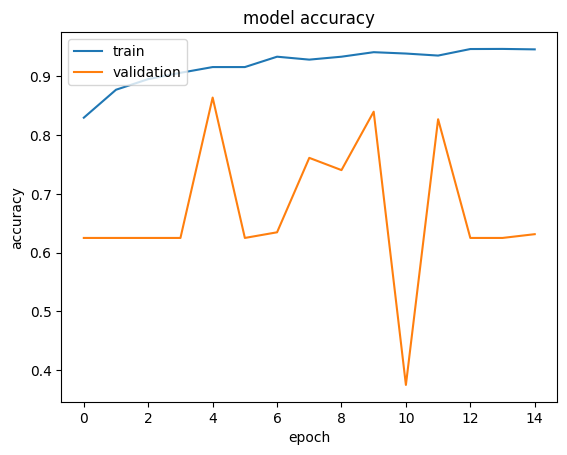

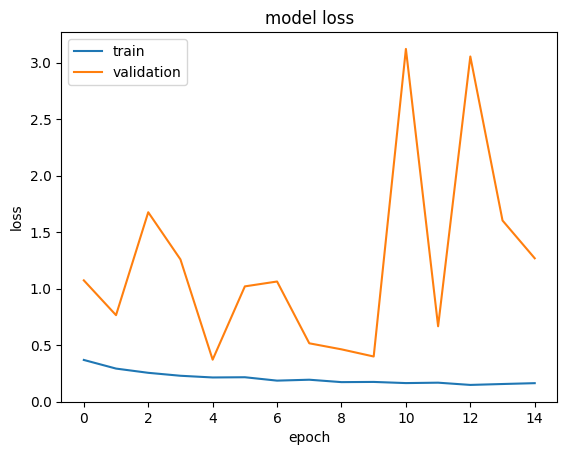

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

# load the trained CNN model
cnn_model = load_model(MODEL_LOC)

In [ ]:
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 674ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve

In [ ]:
# confusion matrix for test dataset
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix for Test Dataset
 -------------------------
[[175  59]
 [ 10 380]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

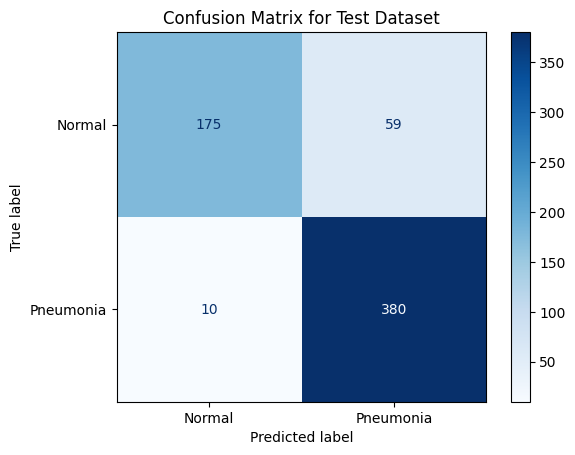

In [ ]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

In [ ]:
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



In [ ]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')

ROC AUC (Test Dataset) 0.95


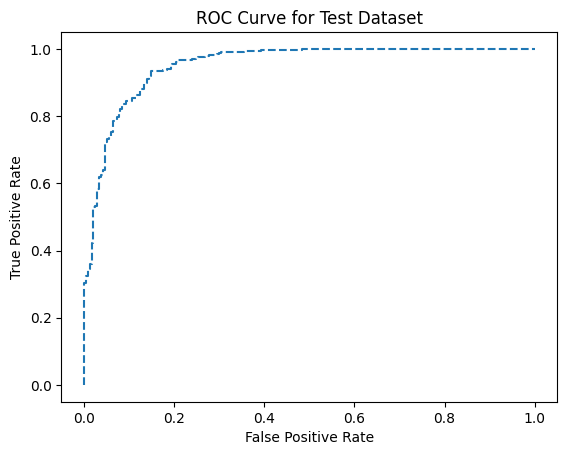

In [ ]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

In [ ]:
# storing the true classes of the test dataset
y_true_val = val_dataset.classes

# predicting the classes of the test dataset
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step



Confusion Matrix for Validation Dataset
 -------------------------
[[3 5]
 [0 8]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

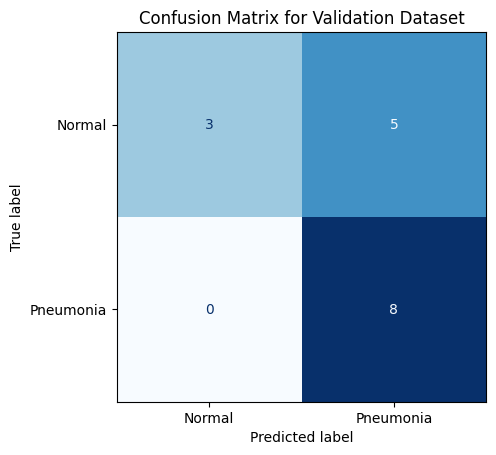

In [ ]:
# confusion matrix for validation dataset
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')